<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, компании необходимо спрогнозировать количество заказов такси на следующий час.

**Задача** - построить модель для предсказания количество заказов такси на ближайший час.

**Описание данных**

Датасет состоит из двух столбцов. Количество заказов находится в столбце 'num_orders'. Во втором столбце находится дата и время сбора данных.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose


Загружаем данные, сразу преобразуя дату в формат данных datetime, и задаем дату как индекс.

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

In [3]:
display(df.head())
display(df.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


None

## Анализ

Сделаем ресемплирование данных по одному часу

In [4]:
df_1h = df.resample('1H').sum()

Построим почасовой график заказов за одну случайную неделю в мае и июне.

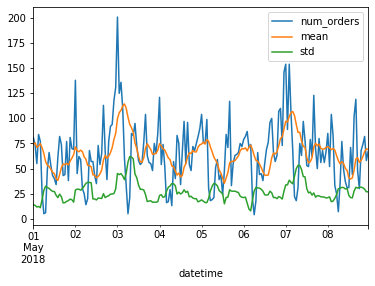

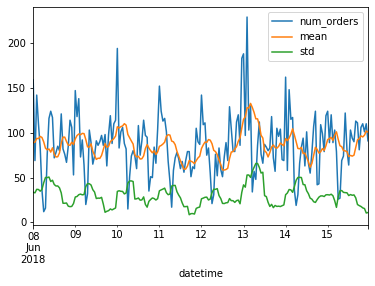

In [5]:
df_1h['mean'] = df_1h['num_orders'].rolling(10).mean()
df_1h['std'] = df_1h['num_orders'].rolling(10).std()
df_1h['2018-05-01': '2018-05-08'].plot()
plt.show()

df_1h['2018-06-08': '2018-06-15'].plot()
plt.show()

Отчетливо прослеживается сезонность данных, а именно, увеличение числа заказов в первые часы суток, тоесть в ночное время. В дневное время наоборот - число заказов падает, потому что многие люди предпочитают общественный транспорт.

Ресемплируем данные по одному дню и построим график заказов за всё предоставленное нам время.

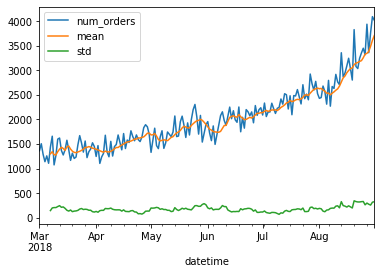

In [6]:
df_1d = df.resample('1D').sum()
df_1d['mean'] = df_1d['num_orders'].rolling(7).mean()
df_1d['std'] = df_1d['num_orders'].rolling(7).std()

df_1d.plot()
plt.show()

Можно наблюдать тренд в данных - плавный рост среднего числа заказов на всем промежутке данных.

Временной ряд не является стационарным, т.к. у него непрерывно растет среднее значение.

Разложим временной ряд на тренд, сезонность и остаток. Построим графики.

In [7]:
df_decomposed = seasonal_decompose(df_1h['num_orders'])

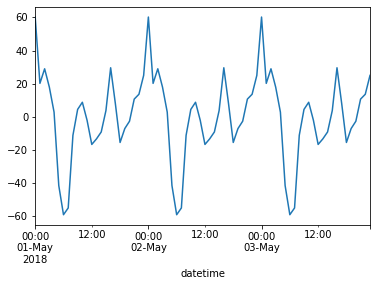

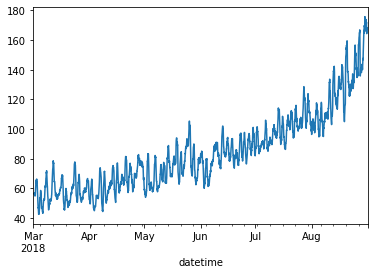

In [8]:
df_decomposed.seasonal['2018-05-01': '2018-05-03'].plot()
plt.show()

df_decomposed.trend.plot()
plt.show()

Наглядно подтвердились отмеченные ранее тренд и сезонность.

## Обучение

Напишем функцию, создающую признаки для горизонта прогнозирования в 1 шаг.
И функцию, вычисляющую RMSE.

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

def rmse(true, pred):
    return mean_squared_error(true, pred) ** 0.5


In [10]:
df_1h = make_features(df_1h, 168, 24)

Разделим данные на обучающую, валидационную и тестовую выборки.

In [11]:
pre_train, test = train_test_split(df_1h, test_size=0.1, shuffle=False)
pre_train = pre_train.dropna()

train, valid = train_test_split(pre_train, test_size=0.25, shuffle=False)

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_valid = valid.drop('num_orders', axis=1)
target_valid = valid['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Обучим разные модели, сравним результаты.

In [12]:
model1 = LinearRegression()
model1.fit(features_train, target_train)
pred1 = model1.predict(features_valid)
print('Linear Regression, RMSE = {:.0f}'.format(rmse(target_valid, pred1)))

Linear Regression, RMSE = 26


In [13]:
model2 = CatBoostRegressor(loss_function='RMSE', iterations=300)
model2.fit(features_train, target_train, verbose=30)
pred2 = model2.predict(features_valid)
print('CatBoostRegressor, RMSE = {:.0f}'.format(rmse(target_valid, pred2)))

0:	learn: 33.4450352	total: 110ms	remaining: 32.9s
30:	learn: 23.2449515	total: 3.08s	remaining: 26.7s
60:	learn: 19.3942817	total: 6.24s	remaining: 24.5s
90:	learn: 17.8346288	total: 9.31s	remaining: 21.4s
120:	learn: 17.0417304	total: 12.2s	remaining: 18.1s
150:	learn: 16.4889479	total: 15.2s	remaining: 15s
180:	learn: 16.0948263	total: 18.2s	remaining: 11.9s
210:	learn: 15.7245946	total: 21.1s	remaining: 8.92s
240:	learn: 15.3937879	total: 24.1s	remaining: 5.9s
270:	learn: 15.1063851	total: 27.1s	remaining: 2.9s
299:	learn: 14.8126319	total: 30s	remaining: 0us
CatBoostRegressor, RMSE = 26


In [14]:
model3 = LGBMRegressor()
model3.fit(features_train, target_train)
pred3 = model3.predict(features_valid)
print('LGBMRegressor, RMSE = {:.0f}'.format(rmse(target_valid, pred3)))

LGBMRegressor, RMSE = 26


In [15]:
model4 = RandomForestRegressor(n_estimators=100)
model4.fit(features_train, target_train)
pred4 = model4.predict(features_valid)
print('RandomForestRegressor, RMSE = {:.0f}'.format(rmse(target_valid, pred4)))

RandomForestRegressor, RMSE = 27


In [16]:
model5 = DecisionTreeRegressor()
model5.fit(features_train, target_train)
pred5 = model5.predict(features_valid)
print('DecisionTreeRegressor, RMSE = {:.0f}'.format(rmse(target_valid, pred5)))

DecisionTreeRegressor, RMSE = 37


Наилучший результат показывает модель LGBMRegressor

## Тестирование

Проверим модели на тестовой выборке

In [17]:
pred_test = model1.predict(features_test)
print('Linear Regression на тестовой выборке, RMSE = {:.0f}'.format(rmse(target_test, pred_test)))

pred_test = model2.predict(features_test)
print('CatBoostRegressor на тестовой выборке, RMSE = {:.0f}'.format(rmse(target_test, pred_test)))

pred_test = model3.predict(features_test)
print('LGBMRegressor на тестовой выборке, RMSE = {:.0f}'.format(rmse(target_test, pred_test)))

pred_test = model4.predict(features_test)
print('RandomForestRegressor на тестовой выборке, RMSE = {:.0f}'.format(rmse(target_test, pred_test)))

pred_test = model5.predict(features_test)
print('DecisionTreeRegressor на тестовой выборке, RMSE = {:.0f}'.format(rmse(target_test, pred_test)))


Linear Regression на тестовой выборке, RMSE = 37
CatBoostRegressor на тестовой выборке, RMSE = 49
LGBMRegressor на тестовой выборке, RMSE = 48
RandomForestRegressor на тестовой выборке, RMSE = 47
DecisionTreeRegressor на тестовой выборке, RMSE = 62


Наилучший результат на валидационной и тестовой выборках у Линейной Регрессии

## Выводы

В данной работе были получены данные о заказах такси из аэропорта. Данные были ресемплированы по одному часу. 

Анализ данных показал наличие сезонности в одни сутки и наличие тренда на всем отрезке исследуемого времени.

Была создана функция, создающая признаки для обучения моделей. Опытным путем было получено, что оптимальное количество лагов - 24х7, т.е. количество часов в неделе, а оптимальный размер окна - 24 часа.

Были обучены 5 моделей. Гиперпараметры были перебраны вручную, какой-либо значимый результат получен не был, поэтому было принято решение оставить параметры по умолчанию. На валидационной выборке одинаково хорошие результаты показали модели бустинга и линейной регрессии, однако на тестовой выборке лучшей оказалась линейная регрессия.